In [1]:
# pad your sequences

from torch.nn.utils.rnn import pad_sequence
from pytorch_lightning.callbacks import LearningRateMonitor
import torch
import numpy as np
from PIL import Image
import os
from collections import defaultdict
import json
import joblib
from torch.utils.data import Dataset,DataLoader,random_split
from itertools import repeat
import pandas as pd
import math
import torch.nn as nn
import torch.nn.functional as F
from numpy import linalg as LA
from argparse import Namespace
from numpy import genfromtxt
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
import wandb
import logging
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint,LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import clip


import wandb
import logging
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import os

logger = logging.getLogger(__name__)
wandb_logger = lambda dir, version: WandbLogger(
    name="wandb", save_dir=dir, version=version
)
csvlogger = lambda dir, version: CSVLogger(dir, name="csvlogs", version=version)
tblogger = lambda dir, version: TensorBoardLogger(dir, name="tblogs", version=version)

def get_loggers(dir,version,lis=["csv"]):
    lgrs = []
    if "wandb" in lis:
        lgrs.append(wandb_logger(dir, version))
    if "csv" in lis:
        lgrs.append(csvlogger(dir, version))
    if "tb" in lis:
        lgrs.append(tblogger(dir, version))
    return lgrs







def get_vid_ids(split='training',\
    annotns_file='/common/home/vk405/Projects/Crossmdl/Data/YouCookII/annotations/youcookii_annotations_trainval.json'):
    # Returns vid_ids corresponding to the split: 'training'/'validation'
    
    vid_lis = []
    with open(annotns_file) as json_file:
        annotns = json.load(json_file)['database']
        for key in annotns:
            if annotns[key]['subset'] == split:
                vid_lis.append(key)
    return vid_lis


def get_split_files(split='training',\
    annotns_file='/common/home/vk405/Projects/Crossmdl/Data/YouCookII/annotations/youcookii_annotations_trainval.json',\
        data_dir = '/common/users/vk405/Youcook/'):
    total_ids = get_vid_ids(split,annotns_file)
    downloaded_ids = set([dir for dir in os.listdir(data_dir) if 'joblib' not in dir])
    vid_locs = []
    sents = {}
    segs = {}
    incomplete = []
    for id in total_ids:
        if id in downloaded_ids:
            vid_loc = data_dir+id + '/'
            if len(os.listdir(vid_loc))>=495:
                vid_locs.append(vid_loc)
                seg = joblib.load(data_dir+f'{id}global_segs.joblib')
                sent = joblib.load(data_dir+f'{id}global_sents.joblib')
                try:
                    sents[id] = sent[id]
                    segs[id] = seg[id]
                except:
                    print(f"{id} is no corresponding global sent/seg")
            else:
                #print(f"{id} has only imgs {len(os.listdir(vid_loc))}")
                incomplete.append(id)
    return vid_locs,segs,sents,incomplete 



/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pathlib

FEAT_DIR = pathlib.Path('/common/users/vk405/CLIP_FEAT')
RAWFRAME_DIR = pathlib.Path('/common/users/vk405/Youcook/')
tokens =  {'O':0,'B':1,'I':2}

# class Dset(Dataset):
#     def __init__(self,data_dir,feat_dir,split):
#         self.data_dir = data_dir
#         self.feat_dir = feat_dir
#         self.split = split
#         self.vid_ids,self.sents = self.get_ids()
#         self.labels = self.getlabels()
#         self.sanitycheck()
#         #self.data = self.getdata()
        
#     def segs_class(self,segs):
#         out = np.zeros(500)
#         for seg in segs:
#             st,end = seg
#             out[st] = tokens['B']
#             out[st+1:end+1] = tokens['I']
#         return out    


#     def sanitycheck(self):
#         mis = []
#         #import pdb;pdb.set_trace()
#         for key in self.labels.keys():
#             txt_loc = self.feat_dir/self.split/f'txt_{key}.joblib'
#             txt = joblib.load(txt_loc)
#             if len(self.labels[key]) == len(self.sents[key]) == len(txt):
#                 pass
#             else:
#                 print(key)
#                 mis.append(key)
#         print(f"segs are not matching:{mis}")
#         for key in mis:
#             self.vid_ids.remove(key)
#         self.sents = None

        
        

#     def __len__(self):
#         return len(self.vid_ids)

#     def __getitem__(self,idx):
#         return self.load(self.vid_ids[idx])

#     def load(self,vid_id):
#         vid_frames_loc = self.feat_dir/self.split/f'vid_{vid_id}.joblib'
#         txt_loc = self.feat_dir/self.split/f'txt_{vid_id}.joblib'
#         vid = joblib.load(vid_frames_loc)
#         try:
#             txt = joblib.load(txt_loc)
#         except:
#             import pdb;pdb.set_trace()
#         segs = self.labels[vid_id]
#         labels = self.segs_class(segs)
#         return vid,txt,labels

#     def getlabels(self):
#         label_dict = {}
#         for vidid in self.vid_ids:
#             vidloc = self.data_dir/vidid
#             segs = self.extract_seg(vidloc)
#             label_dict[vidid] = segs
#         return label_dict
    
#     def extract_seg(self,vid_loc):
#         imgs = sorted(os.listdir(vid_loc),key=lambda x: int(x.split('_')[0]))
#         segs = defaultdict(list)
#         for img in imgs:
#             ind,rem = int(img.split('_')[0]),img.split('_')[-1]
            
#             if 'n.' not in rem:
#                 #print(ind,rem)
#                 seg_id = int(rem.split('.')[0])
#                 segs[seg_id].append(ind)
#                 #print(seg_id,ind)
#         final_segs = []
#         #import pdb;pdb.set_trace()
#         segids = sorted(segs.keys())
#         for segid in segids:
#             final_segs.append((min(segs[segid]),max(segs[segid])))
#         return final_segs
        
#     def get_ids(self):
#         annotns_file='/common/home/vk405/Projects/Crossmdl/Data/YouCookII/annotations/youcookii_annotations_trainval.json'
#         data_dir = '/common/users/vk405/Youcook/'
#         vid_locs,_,sents,_ = get_split_files(self.split,annotns_file,data_dir)
#         ids = [ele.split('/')[-2] for ele in vid_locs]
#         files = set(os.listdir(self.feat_dir/self.split))
#         finids = []
#         missing = []
#         for id in ids:
#             if f'vid_{id}.joblib' in files:
#                 finids.append(id)
#             else:missing.append(id)
#         print(f"missing:{missing}")
#         return finids,sents

        

In [3]:
# modified with #nclasses
class Dset(Dataset):
    def __init__(self,data_dir,feat_dir,split):
        self.data_dir = data_dir
        self.feat_dir = feat_dir
        self.split = split
        self.vid_ids,self.sents = self.get_ids()
        self.labels = self.getlabels()
        self.sanitycheck()
        #self.data = self.getdata()
        
    def segs_class(self,segs):
        out = np.zeros(500)
        for segid,seg in enumerate(segs):
            st,end = seg
            out[st:end+1] = segid+1
        return out    


    def sanitycheck(self):
        mis = []
        #import pdb;pdb.set_trace()
        for key in self.labels.keys():
            txt_loc = self.feat_dir/self.split/f'txt_{key}.joblib'
            txt = joblib.load(txt_loc)
            if len(self.labels[key]) == len(self.sents[key]) == len(txt):
                pass
            else:
                print(key)
                mis.append(key)
        print(f"segs are not matching:{mis}")
        for key in mis:
            self.vid_ids.remove(key)
        self.sents = None

        
        

    def __len__(self):
        return len(self.vid_ids)

    def __getitem__(self,idx):
        return self.load(self.vid_ids[idx])

    def load(self,vid_id):
        vid_frames_loc = self.feat_dir/self.split/f'vid_{vid_id}.joblib'
        txt_loc = self.feat_dir/self.split/f'txt_{vid_id}.joblib'
        vid = joblib.load(vid_frames_loc)
        try:
            txt = joblib.load(txt_loc)
        except:
            import pdb;pdb.set_trace()
        segs = self.labels[vid_id]
        labels = self.segs_class(segs)
        return vid,txt,labels

    def getlabels(self):
        label_dict = {}
        for vidid in self.vid_ids:
            vidloc = self.data_dir/vidid
            segs = self.extract_seg(vidloc)
            label_dict[vidid] = segs
        return label_dict
    
    def extract_seg(self,vid_loc):
        imgs = sorted(os.listdir(vid_loc),key=lambda x: int(x.split('_')[0]))
        segs = defaultdict(list)
        for img in imgs:
            ind,rem = int(img.split('_')[0]),img.split('_')[-1]
            
            if 'n.' not in rem:
                #print(ind,rem)
                seg_id = int(rem.split('.')[0])
                segs[seg_id].append(ind)
                #print(seg_id,ind)
        final_segs = []
        #import pdb;pdb.set_trace()
        segids = sorted(segs.keys())
        for segid in segids:
            final_segs.append((min(segs[segid]),max(segs[segid])))
        return final_segs
        
    def get_ids(self):
        annotns_file='/common/home/vk405/Projects/Crossmdl/Data/YouCookII/annotations/youcookii_annotations_trainval.json'
        data_dir = '/common/users/vk405/Youcook/'
        vid_locs,_,sents,_ = get_split_files(self.split,annotns_file,data_dir)
        ids = [ele.split('/')[-2] for ele in vid_locs]
        files = set(os.listdir(self.feat_dir/self.split))
        finids = []
        missing = []
        for id in ids:
            if f'vid_{id}.joblib' in files:
                finids.append(id)
            else:missing.append(id)
        print(f"missing:{missing}")
        return finids,sents



In [3]:
d = Dset(RAWFRAME_DIR,FEAT_DIR,'training')

missing:['ukfCQQpZ0k4', 'NK2xHVWojgY', 'mixdagZ-fwI']
cwsDQ7M5OTI
uf65nfh6X2U
segs are not matching:['cwsDQ7M5OTI', 'uf65nfh6X2U']


In [6]:
lcnt = []
for key in d.labels.keys():
    sz = len(d.labels[key])
    lcnt.append(sz)

In [8]:
pd.Series(lcnt).describe()

count    1189.000000
mean        7.747687
std         2.824899
min         3.000000
25%         5.000000
50%         7.000000
75%        10.000000
max        16.000000
dtype: float64

In [9]:
d = Dset(RAWFRAME_DIR,FEAT_DIR,'validation')
lcnt = []
for key in d.labels.keys():
    sz = len(d.labels[key])
    lcnt.append(sz)
pd.Series(lcnt).describe()

missing:[]
95WMX64RIBc
segs are not matching:['95WMX64RIBc']


count    417.000000
mean       7.683453
std        2.792597
min        3.000000
25%        6.000000
50%        7.000000
75%        9.000000
max       16.000000
dtype: float64

In [52]:
vid,txt,labels = d[0]

In [53]:
vid.shape,txt.shape,labels.shape

((500, 512), (6, 512), (500,))

In [54]:
labels[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Cross Attention Layer

In [4]:
# CROSS-ATTN LAYER
#model utils

#!pip install transformers

def init_parameters_xavier_uniform(model):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

def scaled_dot(query, key, mask_key=None):  
    score = torch.matmul(query, key.transpose(-2, -1))
    score /= math.sqrt(query.size(-1))
    if mask_key is not None:
        score = score.masked_fill(mask_key, -1e18)  # Represents negative infinity
    return score      
            
def attend(query, key, value, mask_key=None, dropout=None):
    # TODO: Implement
    # Use scaled_dot, be sure to mask key
    #smax = nn.Softmax(-1)
    #import pdb;pdb.set_trace()
    score = scaled_dot(query,key,mask_key)  
    attention = F.softmax(score,dim=-1)
    if dropout is not None:#do = nn.Dropout(dropout)
        attention = dropout(attention)
    answer = torch.matmul(attention,value) 
    # Convexly combine value embeddings using attention, this should be just a matrix-matrix multiplication.
    return answer, attention



def split_heads(batch, num_heads):  
    (batch_size, length, dim) = batch.size()  # These are the expected batch dimensions.
    assert dim % num_heads == 0  # Assert that dimension is divisible by the number of heads.
    dim_head = dim // num_heads

    # No new memory allocation
    splitted = batch.view(batch_size, -1, num_heads, dim_head).transpose(1, 2)  
    return splitted  # (batch_size, num_heads, length, dim_head), note that now the last two dimensions are compatible with our attention functions. 




def merge_heads(batch):  
    (batch_size, num_heads, length, dim_head) = batch.size()  # These are the expected batch dimensions.

    # New memory allocation (reshape), can't avoid.
    merged = batch.transpose(1, 2).reshape(batch_size, -1, num_heads * dim_head)
    return merged  # (batch_size, length, dim)


class MultiHeadAttention(nn.Module):
    def __init__(self, dim, num_heads, dropout_rate=0.1):
        super().__init__()
        assert dim % num_heads == 0

        self.linear_query = nn.Linear(dim, dim)
        self.linear_key = nn.Linear(dim, dim)
        self.linear_value = nn.Linear(dim, dim)
        self.linear_final = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout_rate)

        self.num_heads = num_heads

    def forward(self, query, key, value, mask_key=None, layer_cache=None,
              memory_attention=False):
        """
        INPUT
          query: (batch_size, length_query, dim)
          key: (batch_size, length_key, dim)
          value: (batch_size, length_key, dim_value)
          mask_key: (*, 1, length_key) if queries share the same mask, else
                    (*, length_query, length_key)
          layer_cache: if not None, stepwise decoding (cache of key/value)
          memory_attention: doing memory attention in stepwise decoding?
        OUTPUT
          answer: (batch_size, length_query, dim_value)
          attention: (batch_size, num_heads, length_query, length_key) else
        """
        batch_size = query.size(0)

        query = self.linear_query(query)
        query = split_heads(query, self.num_heads)  # (batch_size, num_heads, -1, dim_head)

        def process_key_value(key, value):  # Only called when necessary.
            key = self.linear_key(key)
            key = split_heads(key, self.num_heads)
            value = self.linear_value(value)
            value = split_heads(value, self.num_heads)
            return key, value

        #import pdb;pdb.set_trace()
        if layer_cache is None:
            key, value = process_key_value(key, value)
        else:
            assert query.size(2) == 1  # Stepwise decoding
            
            if memory_attention:
                if layer_cache['memory_key'] is None:  # One-time calculation
                    key, value = process_key_value(key, value)
                    # (batch_size, num_heads, length_memory, dim)
                    layer_cache['memory_key'] = key
                    layer_cache['memory_value'] = value

                key = layer_cache['memory_key']
                value = layer_cache['memory_value']

            else:  # Self-attention during decoding
                key, value = process_key_value(key, value)
                assert key.size(2) == 1 and value.size(2) == 1
                
                # Append to previous.
                if layer_cache['self_key'] is not None:
                    key = torch.cat((layer_cache['self_key'], key), dim=2)
                    value = torch.cat((layer_cache['self_value'], value), dim=2)
                    
                 # (batch_size, num_heads, length_decoded, dim)
                layer_cache['self_key'] = key  # Recache.
                layer_cache['self_value'] = value
        # Because we've splitted embeddings into heads, we must also split the mask. 
        # And because each query uses the same mask for all heads (we don't use different masking for different heads), 
        # we can specify length 1 for the head dimension.
        if mask_key is not None:  
            mask_key = mask_key.unsqueeze(1)  # (batch_size, 1, -1, length_key)

        answer, attention = attend(query, key, value, mask_key, self.dropout)

        answer = merge_heads(answer)  # (batch_size, length_key, dim)
        answer = self.linear_final(answer)

        return answer, attention

class PositionwiseFeedForward(nn.Module):
    def __init__(self, dim, dim_hidden, drop_rate=0.1):
        super().__init__()
        self.w1 = nn.Linear(dim, dim_hidden)
        self.w2 = nn.Linear(dim_hidden, dim)
        self.layer_norm = nn.LayerNorm(dim, eps=1e-6)
        self.drop1 = nn.Dropout(drop_rate)
        self.relu = nn.ReLU()
        self.drop2 = nn.Dropout(drop_rate)
    def forward(self, x):
        inter = self.drop1(self.relu(self.w1(self.layer_norm(x))))
        output = self.drop2(self.w2(inter))
        return output + x




class SinusoidalPositioner(nn.Module):
    def __init__(self, dim, drop_rate=0.1, length_max=5000):
        super().__init__()
        frequency = torch.exp(torch.arange(0, dim, 2) * -(math.log(10000.) / dim))  # Using different frequency for each dim
        positions = torch.arange(0, length_max).unsqueeze(1)
        wave = torch.zeros(length_max, dim)
        wave[:, 0::2] = torch.sin(frequency * positions)
        wave[:, 1::2] = torch.cos(frequency * positions)
        self.register_buffer('wave', wave.unsqueeze(0))  # (1, length_max, dim)
        self.dropout = nn.Dropout(drop_rate)
        self.dim = dim
        self.length_max = length_max
    def forward(self, x, step=-1):
        assert x.size(-2) <= self.length_max

        if step < 0:  # Take the corresponding leftmost embeddings.
            position_encoding = self.wave[:, :x.size(-2), :]
        else:  # Take the embedding at the step.
            position_encoding = self.wave[:, step, :]

        x = x * math.sqrt(self.dim)
        return self.dropout(x + position_encoding)




class TransformerEncoderLayer(nn.Module):

  def __init__(self, dim, num_heads, dim_hidden, drop_rate):
    super().__init__()
    self.layer_norm = nn.LayerNorm(dim, eps=1e-6)
    self.self_attention = MultiHeadAttention(dim, num_heads, drop_rate)
    self.drop = nn.Dropout(drop_rate)
    self.feedforward = PositionwiseFeedForward(dim, dim_hidden, drop_rate)

  def forward(self, source, mask_source=None):
    # TODO: Implement
    #print(source.shape)
    normed = self.layer_norm(source)  
    # Apply layer norm on source

    attended, attention = self.self_attention(normed,normed,normed,mask_source)
    #None, None  # Apply self-attention on normed (be sure to use mask_source).
    attended = self.drop(attended) + source  
    # Re-write attended by applying dropout and adding a residual connection to source.
    return self.feedforward(attended), attention




class CrossAttentionLayer(nn.Module):
    def __init__(self,dim,num_heads,dim_hidden,drop_rate):
        super().__init__()
        self.layer_norm = nn.LayerNorm(dim, eps=1e-6)
        self.context_attention = MultiHeadAttention(dim, num_heads, drop_rate)
        self.drop = nn.Dropout(drop_rate)
        self.feedforward = PositionwiseFeedForward(dim, dim_hidden, drop_rate)
        
    def forward(self,target,memory,layer_cache=None):
        
        cross_attn_target = self.layer_norm(target)
        attended, attention = self.context_attention(cross_attn_target,memory,memory,layer_cache=layer_cache,memory_attention=True)
        
        attended = target + self.drop(attended)
        
        return self.feedforward(attended),attention



layer_cache = {'memory_key': None, 'memory_value': None, 'self_key': None, 'self_value': None}


In [56]:
crattnlyr = CrossAttentionLayer(10,1,5,0.1)

In [57]:
target = torch.tensor(np.random.randn(1,1,10))
memory = torch.tensor(np.random.randn(1,4,10))

In [58]:
attended_ = crattnlyr(target.float(),memory.float())

In [59]:
out,attn = attended_

In [60]:
lstm = nn.LSTM(512,256,\
        1,bidirectional=True,batch_first=True)

In [61]:
vid_t = torch.unsqueeze(torch.tensor(vid),dim=0)

In [62]:
vid_t.shape

torch.Size([1, 500, 512])

In [63]:
hiddens, (final_h, final_c) = lstm(torch.tensor(vid_t).float())

<ipython-input-63-58f91acf25d3>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hiddens, (final_h, final_c) = lstm(torch.tensor(vid_t).float())


In [64]:
hiddens.shape

torch.Size([1, 500, 512])

In [65]:
txt_t = torch.unsqueeze(torch.tensor(txt),0)
txt_t.shape

torch.Size([1, 6, 512])

In [66]:
croattnlyr = CrossAttentionLayer(512,1,100,0.1)

In [67]:
out,attn = croattnlyr(hiddens,txt_t.float())

In [68]:
out.shape, attn.shape

(torch.Size([1, 500, 512]), torch.Size([1, 1, 500, 6]))

In [5]:
class LstmAttn(nn.Module):
    def __init__(self,lstm_lyrs,lstm_hdim,bidirectional,input_dim,nheads,attn_hdim,attn_dropout,tgt_dim):
        self.lstm_lyrs,self.lstm_hdim,self.bidirectional,self.input_dim,self.nheads,self.attn_hdim,self.attn_dropout,self.tgt_dim = \
            lstm_lyrs,lstm_hdim,bidirectional,input_dim,nheads,attn_hdim,attn_dropout,tgt_dim
        super().__init__()
        if bidirectional:
            #as lstm concates both directions
            lstm_hdim = lstm_hdim//2
        self.lstm = nn.LSTM(input_dim,lstm_hdim,\
        lstm_lyrs,bidirectional=bidirectional,batch_first=True)
        self.crossattn = CrossAttentionLayer(self.lstm_hdim,nheads,attn_hdim,attn_dropout)
        self.txt_enc = nn.Linear(input_dim,self.lstm_hdim)
        self.attn_weights = None
        self.act = nn.ReLU()
        self.tgt_enc = nn.Linear(self.lstm_hdim,tgt_dim)

    def forward(self,vid,txt):
        #import pdb;pdb.set_trace()
        hiddens, (final_h, final_c) = self.lstm(vid)
        txt_inp = self.act(self.txt_enc(txt))
        out_emb,self.attn_weights = self.crossattn(hiddens,txt_inp)
        tgt_emb = self.tgt_enc(out_emb)
        return tgt_emb
        

        

In [70]:
# m = LstmAttn(**cfg.emission_model)
# tgt = m(vid.float(),txt.float())

torch.Size([1, 500, 3])

## CRF MODULE

In [6]:
from typing import List, Optional

import torch
import torch.nn as nn


class CRF(nn.Module):
    """Conditional random field.
    This module implements a conditional random field [LMP01]_. The forward computation
    of this class computes the log likelihood of the given sequence of tags and
    emission score tensor. This class also has `~CRF.decode` method which finds
    the best tag sequence given an emission score tensor using `Viterbi algorithm`_.
    Args:
        num_tags: Number of tags.
        batch_first: Whether the first dimension corresponds to the size of a minibatch.
    Attributes:
        start_transitions (`~torch.nn.Parameter`): Start transition score tensor of size
            ``(num_tags,)``.
        end_transitions (`~torch.nn.Parameter`): End transition score tensor of size
            ``(num_tags,)``.
        transitions (`~torch.nn.Parameter`): Transition score tensor of size
            ``(num_tags, num_tags)``.
    .. [LMP01] Lafferty, J., McCallum, A., Pereira, F. (2001).
       "Conditional random fields: Probabilistic models for segmenting and
       labeling sequence data". *Proc. 18th International Conf. on Machine
       Learning*. Morgan Kaufmann. pp. 282–289.
    .. _Viterbi algorithm: https://en.wikipedia.org/wiki/Viterbi_algorithm
    """

    def __init__(self, num_tags: int, batch_first: bool = False) -> None:
        if num_tags <= 0:
            raise ValueError(f'invalid number of tags: {num_tags}')
        super().__init__()
        self.num_tags = num_tags
        self.batch_first = batch_first
        self.start_transitions = nn.Parameter(torch.empty(num_tags))
        self.end_transitions = nn.Parameter(torch.empty(num_tags))
        self.transitions = nn.Parameter(torch.empty(num_tags, num_tags))

        self.reset_parameters()

    def reset_parameters(self) -> None:
        """Initialize the transition parameters.
        The parameters will be initialized randomly from a uniform distribution
        between -0.1 and 0.1.
        """
        nn.init.uniform_(self.start_transitions, -0.1, 0.1)
        nn.init.uniform_(self.end_transitions, -0.1, 0.1)
        nn.init.uniform_(self.transitions, -0.1, 0.1)
        

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(num_tags={self.num_tags})'

    def forward(
            self,
            emissions: torch.Tensor,
            tags: torch.LongTensor,
            mask: Optional[torch.ByteTensor] = None,
            reduction: str = 'sum',
    ) -> torch.Tensor:
        """Compute the conditional log likelihood of a sequence of tags given emission scores.
        Args:
            emissions (`~torch.Tensor`): Emission score tensor of size
                ``(seq_length, batch_size, num_tags)`` if ``batch_first`` is ``False``,
                ``(batch_size, seq_length, num_tags)`` otherwise.
            tags (`~torch.LongTensor`): Sequence of tags tensor of size
                ``(seq_length, batch_size)`` if ``batch_first`` is ``False``,
                ``(batch_size, seq_length)`` otherwise.
            mask (`~torch.ByteTensor`): Mask tensor of size ``(seq_length, batch_size)``
                if ``batch_first`` is ``False``, ``(batch_size, seq_length)`` otherwise.
            reduction: Specifies  the reduction to apply to the output:
                ``none|sum|mean|token_mean``. ``none``: no reduction will be applied.
                ``sum``: the output will be summed over batches. ``mean``: the output will be
                averaged over batches. ``token_mean``: the output will be averaged over tokens.
        Returns:
            `~torch.Tensor`: The log likelihood. This will have size ``(batch_size,)`` if
            reduction is ``none``, ``()`` otherwise.
        """
        self._validate(emissions, tags=tags, mask=mask)
        if reduction not in ('none', 'sum', 'mean', 'token_mean'):
            raise ValueError(f'invalid reduction: {reduction}')
        if mask is None:
            mask = torch.ones_like(tags, dtype=torch.uint8)

        if self.batch_first:
            emissions = emissions.transpose(0, 1)
            tags = tags.transpose(0, 1)
            mask = mask.transpose(0, 1)

        # shape: (batch_size,)
        numerator = self._compute_score(emissions, tags, mask)
        # shape: (batch_size,)
        denominator = self._compute_normalizer(emissions, mask)
        # shape: (batch_size,)
        llh = numerator - denominator

        if reduction == 'none':
            return llh
        if reduction == 'sum':
            return llh.sum()
        if reduction == 'mean':
            return llh.mean()
        assert reduction == 'token_mean'
        return llh.sum() / mask.type_as(emissions).sum()

    def decode(self, emissions: torch.Tensor,
               mask: Optional[torch.ByteTensor] = None) -> List[List[int]]:
        """Find the most likely tag sequence using Viterbi algorithm.
        Args:
            emissions (`~torch.Tensor`): Emission score tensor of size
                ``(seq_length, batch_size, num_tags)`` if ``batch_first`` is ``False``,
                ``(batch_size, seq_length, num_tags)`` otherwise.
            mask (`~torch.ByteTensor`): Mask tensor of size ``(seq_length, batch_size)``
                if ``batch_first`` is ``False``, ``(batch_size, seq_length)`` otherwise.
        Returns:
            List of list containing the best tag sequence for each batch.
        """
        self._validate(emissions, mask=mask)
        if mask is None:
            mask = emissions.new_ones(emissions.shape[:2], dtype=torch.uint8)

        if self.batch_first:
            emissions = emissions.transpose(0, 1)
            mask = mask.transpose(0, 1)

        return self._viterbi_decode(emissions, mask)

    def _validate(
            self,
            emissions: torch.Tensor,
            tags: Optional[torch.LongTensor] = None,
            mask: Optional[torch.ByteTensor] = None) -> None:
        if emissions.dim() != 3:
            raise ValueError(f'emissions must have dimension of 3, got {emissions.dim()}')
        if emissions.size(2) != self.num_tags:
            raise ValueError(
                f'expected last dimension of emissions is {self.num_tags}, '
                f'got {emissions.size(2)}')

        if tags is not None:
            if emissions.shape[:2] != tags.shape:
                raise ValueError(
                    'the first two dimensions of emissions and tags must match, '
                    f'got {tuple(emissions.shape[:2])} and {tuple(tags.shape)}')

        if mask is not None:
            if emissions.shape[:2] != mask.shape:
                raise ValueError(
                    'the first two dimensions of emissions and mask must match, '
                    f'got {tuple(emissions.shape[:2])} and {tuple(mask.shape)}')
            no_empty_seq = not self.batch_first and mask[0].all()
            no_empty_seq_bf = self.batch_first and mask[:, 0].all()
            if not no_empty_seq and not no_empty_seq_bf:
                raise ValueError('mask of the first timestep must all be on')

    def _compute_score(
            self, emissions: torch.Tensor, tags: torch.LongTensor,
            mask: torch.ByteTensor) -> torch.Tensor:
        # emissions: (seq_length, batch_size, num_tags)
        # tags: (seq_length, batch_size)
        # mask: (seq_length, batch_size)
        assert emissions.dim() == 3 and tags.dim() == 2
        assert emissions.shape[:2] == tags.shape
        assert emissions.size(2) == self.num_tags
        assert mask.shape == tags.shape
        assert mask[0].all()

        seq_length, batch_size = tags.shape
        mask = mask.type_as(emissions)

        # Start transition score and first emission
        # shape: (batch_size,)
        score = self.start_transitions[tags[0]]
        score += emissions[0, torch.arange(batch_size), tags[0]]

        for i in range(1, seq_length):
            # Transition score to next tag, only added if next timestep is valid (mask == 1)
            # shape: (batch_size,)
            score += self.transitions[tags[i - 1], tags[i]] * mask[i]

            # Emission score for next tag, only added if next timestep is valid (mask == 1)
            # shape: (batch_size,)
            score += emissions[i, torch.arange(batch_size), tags[i]] * mask[i]

        # End transition score
        # shape: (batch_size,)
        seq_ends = mask.long().sum(dim=0) - 1
        # shape: (batch_size,)
        last_tags = tags[seq_ends, torch.arange(batch_size)]
        # shape: (batch_size,)
        score += self.end_transitions[last_tags]

        return score

    def _compute_normalizer(
            self, emissions: torch.Tensor, mask: torch.ByteTensor) -> torch.Tensor:
        # emissions: (seq_length, batch_size, num_tags)
        # mask: (seq_length, batch_size)
        assert emissions.dim() == 3 and mask.dim() == 2
        assert emissions.shape[:2] == mask.shape
        assert emissions.size(2) == self.num_tags
        assert mask[0].all()

        seq_length = emissions.size(0)

        # Start transition score and first emission; score has size of
        # (batch_size, num_tags) where for each batch, the j-th column stores
        # the score that the first timestep has tag j
        # shape: (batch_size, num_tags)
        score = self.start_transitions + emissions[0]

        for i in range(1, seq_length):
            # Broadcast score for every possible next tag
            # shape: (batch_size, num_tags, 1)
            broadcast_score = score.unsqueeze(2)

            # Broadcast emission score for every possible current tag
            # shape: (batch_size, 1, num_tags)
            broadcast_emissions = emissions[i].unsqueeze(1)

            # Compute the score tensor of size (batch_size, num_tags, num_tags) where
            # for each sample, entry at row i and column j stores the sum of scores of all
            # possible tag sequences so far that end with transitioning from tag i to tag j
            # and emitting
            # shape: (batch_size, num_tags, num_tags)
            next_score = broadcast_score + self.transitions + broadcast_emissions

            # Sum over all possible current tags, but we're in score space, so a sum
            # becomes a log-sum-exp: for each sample, entry i stores the sum of scores of
            # all possible tag sequences so far, that end in tag i
            # shape: (batch_size, num_tags)
            next_score = torch.logsumexp(next_score, dim=1)

            # Set score to the next score if this timestep is valid (mask == 1)
            # shape: (batch_size, num_tags)
            score = torch.where(mask[i].unsqueeze(1), next_score, score)

        # End transition score
        # shape: (batch_size, num_tags)
        score += self.end_transitions

        # Sum (log-sum-exp) over all possible tags
        # shape: (batch_size,)
        return torch.logsumexp(score, dim=1)

    def _viterbi_decode(self, emissions: torch.FloatTensor,
                        mask: torch.ByteTensor) -> List[List[int]]:
        # emissions: (seq_length, batch_size, num_tags)
        # mask: (seq_length, batch_size)
        assert emissions.dim() == 3 and mask.dim() == 2
        assert emissions.shape[:2] == mask.shape
        assert emissions.size(2) == self.num_tags
        assert mask[0].all()

        seq_length, batch_size = mask.shape

        # Start transition and first emission
        # shape: (batch_size, num_tags)
        score = self.start_transitions + emissions[0]
        history = []

        # score is a tensor of size (batch_size, num_tags) where for every batch,
        # value at column j stores the score of the best tag sequence so far that ends
        # with tag j
        # history saves where the best tags candidate transitioned from; this is used
        # when we trace back the best tag sequence

        # Viterbi algorithm recursive case: we compute the score of the best tag sequence
        # for every possible next tag
        for i in range(1, seq_length):
            # Broadcast viterbi score for every possible next tag
            # shape: (batch_size, num_tags, 1)
            broadcast_score = score.unsqueeze(2)

            # Broadcast emission score for every possible current tag
            # shape: (batch_size, 1, num_tags)
            broadcast_emission = emissions[i].unsqueeze(1)

            # Compute the score tensor of size (batch_size, num_tags, num_tags) where
            # for each sample, entry at row i and column j stores the score of the best
            # tag sequence so far that ends with transitioning from tag i to tag j and emitting
            # shape: (batch_size, num_tags, num_tags)
            next_score = broadcast_score + self.transitions + broadcast_emission

            # Find the maximum score over all possible current tag
            # shape: (batch_size, num_tags)
            next_score, indices = next_score.max(dim=1)

            # Set score to the next score if this timestep is valid (mask == 1)
            # and save the index that produces the next score
            # shape: (batch_size, num_tags)
            score = torch.where(mask[i].unsqueeze(1), next_score, score)
            history.append(indices)

        # End transition score
        # shape: (batch_size, num_tags)
        score += self.end_transitions

        # Now, compute the best path for each sample

        # shape: (batch_size,)
        seq_ends = mask.long().sum(dim=0) - 1
        best_tags_list = []

        for idx in range(batch_size):
            # Find the tag which maximizes the score at the last timestep; this is our best tag
            # for the last timestep
            _, best_last_tag = score[idx].max(dim=0)
            best_tags = [best_last_tag.item()]

            # We trace back where the best last tag comes from, append that to our best tag
            # sequence, and trace it back again, and so on
            for hist in reversed(history[:seq_ends[idx]]):
                best_last_tag = hist[idx][best_tags[-1]]
                best_tags.append(best_last_tag.item())

            # Reverse the order because we start from the last timestep
            best_tags.reverse()
            best_tags_list.append(best_tags)

        return best_tags_list

In [48]:
dec = nn.Linear(512,3)
fout = dec(out)
fout.shape

torch.Size([1, 500, 3])

In [71]:
batch_size,seq_length,num_tags = fout.shape

emissions = torch.reshape(fout,(seq_length, batch_size, num_tags))
emissions.shape

torch.Size([500, 1, 3])

(500,)

In [75]:
 #(seq_length, batch_size)
labels_t = torch.unsqueeze(torch.tensor(labels,dtype=torch.long),dim=-1)
labels_t.shape

torch.Size([500, 1])

In [76]:
labels_t.dtype

torch.int64

In [77]:
model = CRF(3)
loglike = model(emissions,labels_t)

<ipython-input-70-c1eff8546114>:236: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ../aten/src/ATen/native/TensorCompare.cpp:328.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


In [78]:
loglike

tensor(-576.7137, grad_fn=<SumBackward0>)

## CLIP-CRF MODEL

In [7]:
class ScheduledOptim(torch.optim.Optimizer):
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [8]:
class ClipCRF(pl.LightningModule):
    def __init__(self,hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        self.emission_model = LstmAttn(**self.hparams.emission_model)
        self.crf = CRF(self.hparams.emission_model['tgt_dim'])

    def forward(self,vid,txt):
        tgt_emb = self.emission_model(vid.float(),txt.float())
        batch_size,seq_length,num_tags = tgt_emb.shape
        emissions = torch.reshape(tgt_emb,(seq_length, batch_size, num_tags))
        return self.crf.decode(emissions)

    def training_step(self,batch,batch_idx):
        vid,txt,labels = batch
        batch_size,seq_length = labels.shape
        labels = torch.reshape(torch.tensor(labels,dtype=torch.long),(seq_length,batch_size))
        
        tgt_emb = self.emission_model(vid.float(),txt.float())
        batch_size,seq_length,num_tags = tgt_emb.shape
        emissions = torch.reshape(tgt_emb,(seq_length, batch_size, num_tags))
        loglike = self.crf(emissions,labels)
        loss = -1*loglike
        self.log("train_loglikelihood",loglike,on_step=True)
        self.log("train_loss",loss,on_step=True)
        return loss

    def validation_step(self,batch,batch_idx):
        vid,txt,labels = batch
        batch_size,seq_length = labels.shape
        labels = torch.reshape(torch.tensor(labels,dtype=torch.long),(seq_length,batch_size))
        
        tgt_emb = self.emission_model(vid.float(),txt.float())
        batch_size,seq_length,num_tags = tgt_emb.shape
        emissions = torch.reshape(tgt_emb,(seq_length, batch_size, num_tags))
        loglike = self.crf(emissions,labels)
        loss = -1*loglike
        self.log("val_loss",loss,on_step=False,on_epoch=True)
        return loss

    def configure_optimizers(self):
        num_warmup_steps = self.hparams.num_warmup_steps
        lr_dim = self.hparams.lr_dim
        
        optimizer = torch.optim.Adam(self.parameters(),lr=self.hparams.lr,betas=(0.9, 0.98), eps=1e-9)
        #scheduler = ScheduledOptim(optimizer,1,lr_dim,num_warmup_steps)
        return optimizer
    

In [9]:
    cfg = Namespace(
        version = 'clip_crf_vld_ncls',
        id = 0,
        FEAT_DIR = FEAT_DIR,
        RAWFRAME_DIR = RAWFRAME_DIR,
        artifacts_loc = "/common/home/vk405/Projects/Crossmdl/nbs/",
        data_dir = "/common/home/vk405/Projects/Crossmdl/Data/YouCookII/",
        trn_split = 0.8,
        mode = 'train',
        split = 'training',
        loggers = ["csv"],
        seed = 0,
        emission_model = {'bidirectional':True,'input_dim':512,'nheads':1,'lstm_lyrs':1,\
            'lstm_hdim':128,'attn_hdim':64,\
            'attn_dropout':0.0,
            'tgt_dim': 17
            },
        cbs = ["checkpoint"],
        trainer = {'log_every_n_steps': 1, 
        'max_epochs': 60},
        checkpoint = {"every_n_epochs": 1,
        "monitor": "val_loss"},
        early_stop = {"monitor":"val_loss","mode":"min","patience":5},
        lr = 1e-4,
        lr_dim = 200,
        num_warmup_steps = 4000,
        batch_sz = 1
        

    )

In [26]:
df = pd.read_csv('/common/home/vk405/Projects/Crossmdl/nbs/csvlogs/clip_crf_trn_ncls/metrics.csv')

<AxesSubplot:>

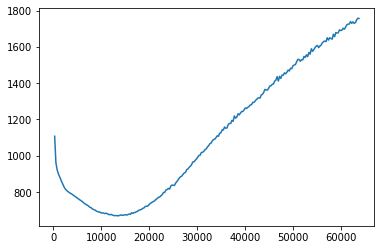

In [48]:
df['val_loss'].dropna().plot()

In [47]:
df.iloc[13514:13518,:]

,lr-Adam,step,train_loglikelihood,train_loss,epoch,val_loss
13514,NaN,847,NaN,NaN,52.0,668.03894
13515,0.0001,848,NaN,NaN,NaN,NaN
13516,0.0001,848,NaN,NaN,NaN,NaN
13517,0.0001,848,NaN,NaN,NaN,NaN


<AxesSubplot:>

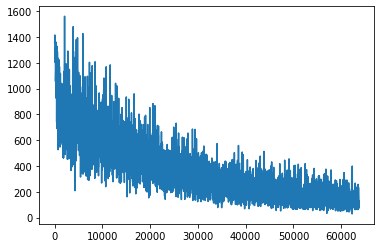

In [31]:
df['train_loss'].dropna().plot()

In [10]:
#m = ClipCRF(cfg)


from pathlib import Path
def get_model(cfg):
    hparams = cfg    
    PATH = Path(cfg.artifacts_loc)/'ckpts'/cfg.version
    ckpt = os.listdir(PATH)[-1]
    net = ClipCRF(hparams)
    print(f"loading ckpt:{ckpt}")
    new_model = net.load_from_checkpoint(checkpoint_path=str(PATH/ckpt))
    return new_model

In [11]:
m = get_model(cfg)

loading ckpt:epoch=46-val_loss=547.01.ckpt


In [12]:
m.crf.transitions[2,:]

tensor([-6.9500e-02, -1.0000e+03,  3.7342e-02, -4.1242e-02, -1.0000e+03,
        -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03, -1.0000e+03], grad_fn=<SliceBackward0>)

In [13]:
d = Dset(cfg.RAWFRAME_DIR,cfg.FEAT_DIR,cfg.split)
trn_sz = int(len(d)*cfg.trn_split)
val_sz = len(d)-trn_sz
trndset,valdset = random_split(d,[trn_sz,val_sz])

trnl = DataLoader(trndset,batch_size=1,shuffle=False,num_workers = 5)

missing:['ukfCQQpZ0k4', 'NK2xHVWojgY', 'mixdagZ-fwI']
cwsDQ7M5OTI
uf65nfh6X2U
segs are not matching:['cwsDQ7M5OTI', 'uf65nfh6X2U']


In [14]:
vid,text,labels  = next(iter(trnl))

In [15]:
vid.shape,text.shape,labels.shape

(torch.Size([1, 500, 512]), torch.Size([1, 9, 512]), torch.Size([1, 500]))

In [15]:
pred_labels = m(vid,text)

<ipython-input-6-be86d3c016ba>:293: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ../aten/src/ATen/native/TensorCompare.cpp:328.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


In [17]:
pred_labels

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,


In [16]:
np.mean(labels.detach().cpu().numpy()[0] == pred_labels)

0.42

In [20]:
pred_labels

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,


In [27]:
labels = [0,0,0,1,2,2,2,1,2]
isinstance(labels,list)

True

In [24]:
def labels_to_segs(labels):
    if isinstance(labels,list) and not isinstance(labels[0],list):
        labels = [labels]
    seglis = []
    def get_segs(labellis):
        segs = []
        st,end = None,None
        for i,ele in enumerate(labellis):
            #print(f"ele:{ele},st:{st},end:{end}")
            if ele == 0:
                if st!=None and end!=None:
                    segs.append((st,end))
                st,end = None,None
            elif ele == 1:
                if st != None and end != None:
                    segs.append((st,end))
                #can start and end at the same token
                st = i
                end = i
                
            elif st!=None and ele == 2:
                end = i
                if i == (len(labellis)-1):segs.append((st,end))
        return segs
    for labellis in labels:
        seg = get_segs(labellis)
        seglis.append(seg)
    return seglis







In [26]:
segs

[(3, 6), (7, 8)]

In [21]:
d_test = Dset(cfg.RAWFRAME_DIR,cfg.FEAT_DIR,'validation')

missing:[]
95WMX64RIBc
segs are not matching:['95WMX64RIBc']


In [22]:
testl = DataLoader(d_test,batch_size=1,shuffle=False,num_workers = 5)

In [23]:
vid,text,labels  = next(iter(testl))

In [24]:
pred_labels = m(vid,text)

In [25]:
np.mean(labels.detach().cpu().numpy()[0] == pred_labels)

0.248

In [25]:
from tqdm import tqdm
def inference(model,dl):
    frame_level_acc = []
    labellis = []
    predlis = []
    model.eval()
    for batch in tqdm(dl):
        vid,text,labels = batch
        pred_labels = model(vid,text)
        ground_labels = labels.detach().cpu().numpy()[0]
        predlis.append(pred_labels)
        labellis.append(ground_labels)
        acc = np.mean(ground_labels == pred_labels)
        frame_level_acc.append(acc)
    return np.mean(frame_level_acc),labellis,predlis
        
        
    

In [70]:
t_fl_acc,labellis,predlis = inference(m,testl)

100%|██████████| 416/416 [01:38<00:00,  4.23it/s]


In [30]:
set(predlis[0][0])

{0, 2}

In [22]:
t_fl_acc

0.7398028846153846

In [31]:
lsegs = labels_to_segs(labellis[0].tolist())


In [32]:
lsegs

[[(147, 239), (254, 270), (282, 329), (333, 354), (361, 411)]]

In [67]:
set(predlis[0][0])

{0, 2}

In [71]:
lsegs = [labels_to_segs(labellis[i].tolist())[0] for i in range(len(labellis))]


In [72]:
psegs = [get_segs(predlis[i][0]) for i in range(len(predlis))]

In [73]:
def get_segs(labellis):
    segs = []
    st,end = None,None
    for i,ele in enumerate(labellis):
        #print(f"ele:{ele},st:{st},end:{end}")
        if ele == 0:
            if st != None and end != None:
                segs.append((st,end))
            st,end = None,None
            
        elif ele == 2:
            if st == None:
                st,end = i,i
            else:
                end = i
               
            if i == (len(labellis)-1):segs.append((st,end))
    return segs

In [71]:
get_segs([0,0,2,2,0,0,2])

[(2, 3), (6, 6)]

In [52]:
get_segs(predlis[0][0])

[(149, 240), (273, 412)]

In [58]:
set(predlis[490][0])

{0, 2}

In [55]:
len(labellis)

949

In [39]:
# vid,txt,labels = batch

preds = [[(149, 240), (273, 412)]]
labels = [[(147, 239), (254, 270), (282, 329), (333, 354), (361, 411)]]

In [74]:
stats(psegs,lsegs)

[]
[(101, 115), (120, 132), (144, 151), (152, 160), (174, 205), (215, 261), (262, 292), (400, 419)]
[]
[(65, 101), (120, 141), (190, 207), (209, 230), (244, 272), (277, 278), (311, 321), (339, 344), (365, 368), (425, 447)]
[]
[(57, 64), (87, 111), (117, 134), (140, 171), (181, 215), (238, 265), (285, 286), (324, 326), (338, 376), (389, 437)]
[]
[(80, 113), (114, 135), (181, 203), (215, 316), (317, 384), (385, 418)]
[]
[(44, 69), (83, 127), (170, 175), (200, 206), (223, 269), (284, 290), (376, 407), (410, 430)]
[]
[(84, 119), (149, 163), (191, 195), (209, 237), (272, 316), (362, 430)]
[]
[(98, 247), (267, 413), (446, 494)]
[]
[(30, 86), (89, 97), (109, 164), (200, 268), (309, 334), (342, 358), (359, 368), (390, 398)]


(0.5555192307692308, 0.28378418504719577, 0.12492428434348384)

In [66]:
#preds: list of lists corresponding to each video. [[(23,67),(89,102)]]
import numpy as np
def stats(preds,labels,sz=500):
    accs = []
    recalls = []
    ious = []
    for pred,label in zip(preds,labels):
        # note: during inference we ensure that intervals are non-overlapping
        #pred = sorted(pred,key=lambda x: x[0])
        #label = sorted(label,key=lambda x: x[0])
        pred_sz = len(pred)
        lbl_sz = len(label)
        pred_lis = np.zeros(sz)
        label_lis = np.zeros(sz)
        for ind in range(1,min(pred_sz+1,lbl_sz+1)):
            p_st,p_end = pred[ind-1]
            l_st,l_end = label[ind-1]
            pred_lis[p_st:l_end+1] = ind
            label_lis[l_st:l_end+1] = ind
        for ind in range(pred_sz+1,len(label)+1):
            #set ground-truth indx's
            l_st,l_end = label[ind-1]
            label_lis[l_st:l_end+1] = ind

        acc = np.mean(pred_lis == label_lis)
        accs.append(acc)
        #calc recall
        #calc iou
        inter_cnt = 0
        union_cnt = 0
        recall_score = []
        for p_seg,l_seg in zip(pred,label):
            ps = set(range(p_seg[0],p_seg[-1]+1))
            ls = set(range(l_seg[0],l_seg[-1]+1))
            inter_cnt += len(ps.intersection(ls))
            union_cnt += len(ps.union(ls))
            #if ps.issubset(ls):
            recall_score.append(len(ls.intersection(ps))/len(ls))
            # correctly assign or fall into ground truth interval
            #recall_score += 1
        ms = len(label)-len(pred)
        #if ms>0:
            #for i in range(ms):
                #recall_score.append(0.0)
        if union_cnt:
            ious.append(inter_cnt/union_cnt)
            recalls.append(np.mean(recall_score))
        else:
            print(pred)
            print(label)
    return np.mean(accs),np.mean(recalls),np.mean(ious)
    

            




        
        
    

In [71]:
# tgt_emb = m.emission_model(vid.float(),txt.float())

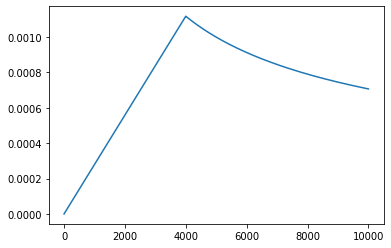

In [17]:
import matplotlib.pyplot as plt
def noam_decay(step, num_warmup_steps, dim):
  # Eq. (3) of the Transfomer paper. 
  return (dim ** (-0.5) * min(step ** (-0.5), step * num_warmup_steps**(-1.5)))

plt.plot([step + 1 for step in range(10000)], [noam_decay(step + 1, 4000, 200) for step in range(10000)])
plt.show()

In [72]:
def run(cfg):
    #pl.seed_everything(cfg.seed)
    dir = cfg.artifacts_loc
    version = str(cfg.version)
    logger_list = get_loggers(dir, version,cfg.loggers)
    cbs = []
    if "early_stop" in cfg.cbs:
        #? does'nt really work atm
        params = cfg.early_stop
        earlystopcb = EarlyStopping(**params, min_delta=0.00, verbose=False)
        cbs.append(earlystopcb)
    if "checkpoint" in cfg.cbs:
        store_path = dir + "ckpts/" + str(cfg.version) + "/"
        isExist = os.path.exists(store_path)
        if not isExist:
            os.makedirs(store_path)
        fname = "{epoch}-{val_loss:.2f}"
        params = cfg.checkpoint
        checkptcb = ModelCheckpoint(**params, dirpath=store_path, filename=fname)
        cbs.append(checkptcb)

    #wandb.init(project="videoretrieval", config=cfg)
    if cfg.mode == 'train':
        d = Dset(cfg.RAWFRAME_DIR,cfg.FEAT_DIR,cfg.split)
        trn_sz = int(len(d)*cfg.trn_split)
        val_sz = len(d)-trn_sz
        trndset,valdset = random_split(d,[trn_sz,val_sz])
        batch_sz = cfg.batch_sz
        trnl = DataLoader(trndset,batch_size=batch_sz,shuffle=True,num_workers = 5)
        vall = DataLoader(valdset,batch_size=batch_sz)
        hparams = cfg  
        lr_monitor = LearningRateMonitor(logging_interval='step')  
        cbs.append(lr_monitor)
        net = ClipCRF(hparams)
        trainer = pl.Trainer(
            logger=logger_list,callbacks=cbs,gpus=1,deterministic=True, **cfg.trainer
        )
        trainer.fit(net, trnl,vall)
        return trainer
        #trainer.tune(net,train_loader)
            
    else:
        pass

In [18]:
from argparse import Namespace
FEAT_DIR = pathlib.Path('/common/users/vk405/CLIP_FEAT')
RAWFRAME_DIR = pathlib.Path('/common/users/vk405/Youcook/')
#early_stop
#lstm_lyrs,lstm_hdim,bidirectional,input_dim,nheads,attn_hdim,attn_dropout,tgt_dim
cfg = Namespace(
    version = 'clip_crf_trn',
    id = 0,
    FEAT_DIR = FEAT_DIR,
    RAWFRAME_DIR = RAWFRAME_DIR,
    artifacts_loc = "/common/home/vk405/Projects/Crossmdl/nbs/",
    data_dir = "/common/home/vk405/Projects/Crossmdl/Data/YouCookII/",
    trn_split = 0.8,
    mode = 'train',
    split = 'training',
    loggers = ["csv"],
    seed = 0,
    emission_model = {'bidirectional':True,'input_dim':512,'nheads':1,'lstm_lyrs':1,\
        'lstm_hdim':128,'attn_hdim':64,\
        'attn_dropout':0.0,
        'tgt_dim': 3
        },
    cbs = ["checkpoint"],
    trainer = {'log_every_n_steps': 1, 
    'max_epochs': 150},
    checkpoint = {"every_n_epochs": 1,
    "monitor": "train_loss"},
    early_stop = {"monitor":"val_loss","mode":"min","patience":5},
    lr = 1e-4,
    lr_dim = 200,
    num_warmup_steps = 4000,
    batch_sz = 1
    

)

In [74]:
#t = run(cfg)

missing:['ukfCQQpZ0k4', 'NK2xHVWojgY', 'mixdagZ-fwI']
cwsDQ7M5OTI
uf65nfh6X2U


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/pytorch_lightning/loggers/csv_logs.py:57: UserWarning: Experiment logs directory /common/home/vk405/Projects/Crossmdl/nbs/csvlogs/clip_crf exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(

  | Name           | Type     | Params
--------------------------------------------
0 | emission_model | LstmAttn | 445 K 
1 | crf            | CRF      | 15    
--------------------------------------------
445 K     Trainable params
0         Non-trainable params
445 K     Total params
1.781     Total estimated model params size (MB)


segs are not matching:['cwsDQ7M5OTI', 'uf65nfh6X2U']
Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
<ipython-input-42-485a44048b33>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.reshape(torch.tensor(labels,dtype=torch.long),(seq_length,batch_size))


NameError: name 'labels_t' is not defined